# Deep Learning with PyTorch: MNIST Classification

This notebook implements a complete deep learning pipeline for MNIST digit classification using PyTorch. It covers data preprocessing, model architecture, training with early stopping, hyperparameter tuning, and advanced techniques including adversarial robustness and GAN-based augmentation.

## Environment Setup and Library Imports

Import all necessary libraries for deep learning, data manipulation, and visualization.

In [ ]:
# Import essential libraries for deep learning and data processing
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split # type: ignore
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

## 1. Data Loading and Preprocessing

This section handles loading the MNIST dataset and applying essential preprocessing steps including normalization and data type conversion. We'll apply data preprocessing while loading the MNIST dataset to convert images to float32, scale pixel values to [0, 1], and normalize using MNIST dataset statistics (mean=0.1307, std=0.3081).

In [ ]:
# Define data transformation pipeline for normalization
basic_transform = transforms.Compose([
    transforms.ToTensor(),                    # Convert PIL image to tensor and scale to [0,1]
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize with MNIST statistics
])

# Download and load MNIST dataset
# Note: We'll split training data into train/validation later
mnist_train = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=basic_transform
)

mnist_test = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=basic_transform
)

print(f'Total training+validation samples: {len(mnist_train)}')
print(f'Test samples: {len(mnist_test)}')

Total training+validation samples: 60000
Test samples: 10000


## 2. Exploratory Data Analysis (EDA)

Let's explore our dataset to better understand its structure and characteristics. We'll visualize sample images to see what our data looks like and examine the class distribution to ensure the dataset is balanced across different digits.

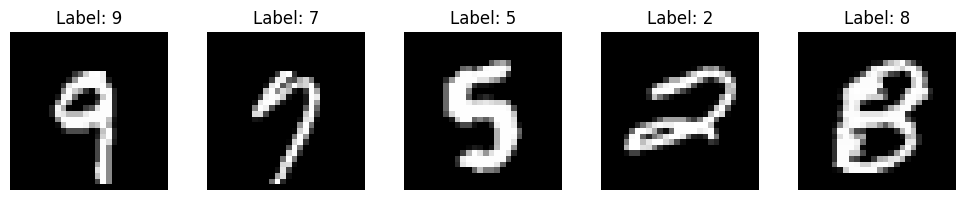

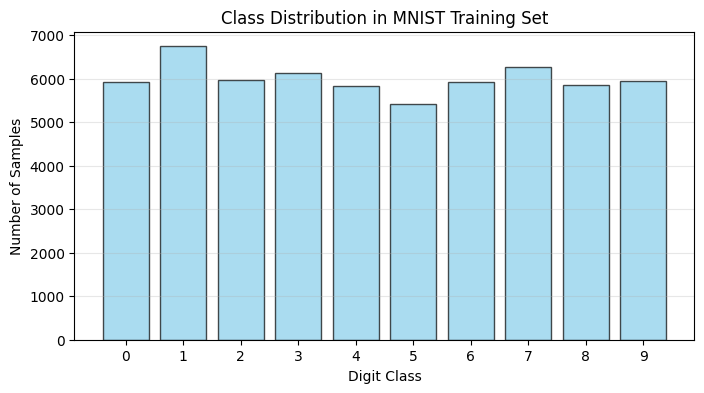

Dataset is imbalanced


In [ ]:
# Visualize random sample images from the dataset
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    idx = np.random.randint(0, len(mnist_train))
    img, label = mnist_train[idx]
    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Analyze class distribution across all digits
labels = [mnist_train[i][1] for i in range(len(mnist_train))]

plt.figure(figsize=(8, 4))
plt.hist(labels, bins=np.arange(11)-0.5, rwidth=0.8, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Digit Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in MNIST Training Set')
plt.xticks(range(10))
plt.grid(axis='y', alpha=0.3)
plt.show()

print(f"Dataset is {'balanced' if max(np.bincount(labels)) - min(np.bincount(labels)) < 1000 else 'imbalanced'}")

## 3. Data Splitting Strategy

We need to split our data into three sets: training, validation, and test. The test set is already provided by MNIST, so we'll split the training data into 80% for training and 20% for validation. This validation set will help us monitor training progress and implement early stopping to prevent overfitting.

In [ ]:
# Split training data into training and validation sets (80-20 split)
train_size = int(0.8 * len(mnist_train))
val_size = len(mnist_train) - train_size

train_dataset, val_dataset = random_split(
    mnist_train,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # For reproducible splits
)

print(f'Training samples: {len(train_dataset):,}')
print(f'Validation samples: {len(val_dataset):,}')
print(f'Test samples: {len(mnist_test):,}')
print(f'Train/Val ratio: {len(train_dataset)/len(val_dataset):.1f}:1')

Training samples: 48,000
Validation samples: 12,000
Test samples: 10,000
Train/Val ratio: 4.0:1


## 4. Data Augmentation Strategy

Data augmentation helps improve model generalization by artificially expanding our training dataset. We'll apply various transformations like rotation, translation, scaling, and noise to create more diverse training examples. These augmentations will only be applied to the training set to maintain consistency in validation and testing.

In [ ]:
# Define comprehensive augmentation pipeline for training
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=20),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.3),
    transforms.RandomApply([transforms.RandomErasing()], p=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Update only the training set to use augmentation
train_dataset.transform = train_transform
print('✓ Data augmentation applied to training set')
print('✓ Validation and test sets maintain original transforms')

✓ Data augmentation applied to training set
✓ Validation and test sets maintain original transforms


## 5. DataLoader Configuration

DataLoaders handle efficient batch processing and data loading during training. We'll configure appropriate batch sizes and shuffling strategies: shuffle training data for better learning while keeping validation and test data in order for consistent evaluation.

In [ ]:
# Configure DataLoaders for efficient batch processing
BATCH_SIZE = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,           # Shuffle for better training
    num_workers=0,          # Set to 0 for Windows compatibility
    pin_memory=True         # Faster GPU transfer
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,          # No shuffling for consistent validation
    num_workers=0,
    pin_memory=True
)

test_loader = DataLoader(
    mnist_test,
    batch_size=BATCH_SIZE,
    shuffle=False,          # No shuffling for consistent testing
    num_workers=0,
    pin_memory=True
)

# Verify DataLoader functionality
dataiter = iter(train_loader)
sample_images, sample_labels = next(dataiter)

print(f'✓ DataLoaders configured successfully')
print(f'  Batch size: {BATCH_SIZE}')
print(f'  Sample batch shape: {sample_images.shape}')
print(f'  Sample labels shape: {sample_labels.shape}')
print(f'  Number of training batches: {len(train_loader)}')

✓ DataLoaders configured successfully
  Batch size: 64
  Sample batch shape: torch.Size([64, 1, 28, 28])
  Sample labels shape: torch.Size([64])
  Number of training batches: 750


## 6. Model Architecture Design

We'll design a Convolutional Neural Network (CNN) optimized for MNIST classification. The architecture includes two convolutional blocks (Conv-ReLU-Pool) for feature extraction, followed by fully connected layers for classification. Dropout is included for regularization to prevent overfitting.

In [ ]:
# Define CNN architecture for MNIST classification
class MNISTClassifier(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(MNISTClassifier, self).__init__()

        # First convolutional block
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # 28x28 -> 28x28
        self.pool1 = nn.MaxPool2d(2, 2)                                    # 28x28 -> 14x14

        # Second convolutional block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) # 14x14 -> 14x14
        self.pool2 = nn.MaxPool2d(2, 2)                                    # 14x14 -> 7x7

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Feature extraction
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)

        x = torch.relu(self.conv2(x))
        x = self.pool2(x)

        # Classification
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return torch.log_softmax(x, dim=1)

# Initialize model
model = MNISTClassifier(dropout_rate=0.5)

# Display model architecture
print("Model Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

Model Architecture:
MNISTClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Total parameters: 421,642


## 7. Training Setup and Implementation

Now we'll implement the training loop with proper batch processing, loss calculation, and accuracy tracking. We'll include early stopping based on validation loss to prevent overfitting and ensure optimal model performance.

In [ ]:
# 7.1 Training Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Training hyperparameters (optimized for MNIST)
learning_rate = 0.001  # Standard Adam learning rate, good starting point
num_epochs = 15        # MNIST typically converges quickly (5-15 epochs)
patience = 5           # More patience for better convergence

# Loss function and optimizer
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(f'Device: {device}')
print(f'Learning rate: {learning_rate}')
print(f'Number of epochs: {num_epochs}')
print(f'Early stopping patience: {patience}')

Device: cpu
Learning rate: 0.001
Number of epochs: 15
Early stopping patience: 5


In [ ]:
# 7.2 Training and Validation Functions
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

    val_loss /= len(val_loader)
    val_acc = 100. * correct / total
    return val_loss, val_acc

print('Training and validation functions defined.')

Training and validation functions defined.


In [ ]:
# 7.3 Training Loop with Early Stopping
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_loss = float('inf')
epochs_without_improvement = 0

print('Starting training...')
print('Epoch | Train Loss | Train Acc | Val Loss | Val Acc')
print('-' * 50)

for epoch in range(num_epochs):
    # Training phase
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validation phase
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Print progress
    print(f'{epoch+1:5d} | {train_loss:10.4f} | {train_acc:9.2f} | {val_loss:8.4f} | {val_acc:7.2f}')

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        # Save best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f'\nEarly stopping triggered after {epoch+1} epochs')
        break

print('\nTraining completed!')

Starting training...
Epoch | Train Loss | Train Acc | Val Loss | Val Acc
--------------------------------------------------


    1 |     0.2321 |     92.90 |   0.0698 |   97.92
    2 |     0.0889 |     97.38 |   0.0500 |   98.58
    2 |     0.0889 |     97.38 |   0.0500 |   98.58
    3 |     0.0688 |     97.99 |   0.0414 |   98.80
    3 |     0.0688 |     97.99 |   0.0414 |   98.80
    4 |     0.0545 |     98.37 |   0.0397 |   98.92
    4 |     0.0545 |     98.37 |   0.0397 |   98.92
    5 |     0.0472 |     98.58 |   0.0406 |   98.91
    5 |     0.0472 |     98.58 |   0.0406 |   98.91
    6 |     0.0405 |     98.80 |   0.0404 |   98.97
    6 |     0.0405 |     98.80 |   0.0404 |   98.97
    7 |     0.0351 |     98.90 |   0.0394 |   98.97
    7 |     0.0351 |     98.90 |   0.0394 |   98.97
    8 |     0.0327 |     99.05 |   0.0439 |   98.82
    8 |     0.0327 |     99.05 |   0.0439 |   98.82
    9 |     0.0294 |     99.09 |   0.0384 |   99.01
    9 |     0.0294 |     99.09 |   0.0384 |   99.01
   10 |     0.0255 |     99.17 |   0.0371 |   99.08
   10 |     0.0255 |     99.17 |   0.0371 |   99.08
   11 |     

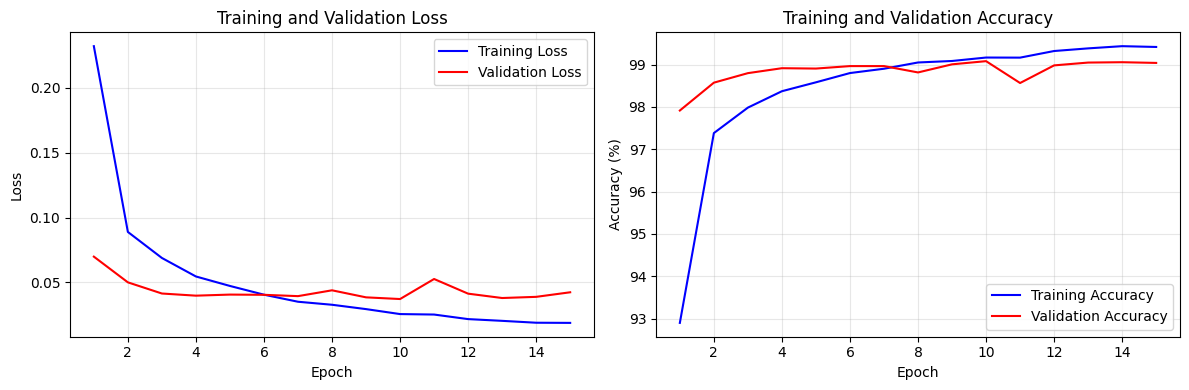

Final Training Loss: 0.0187
Final Training Accuracy: 99.42%
Final Validation Loss: 0.0423
Final Validation Accuracy: 99.04%
Best Validation Loss: 0.0371


In [ ]:
# 7.4 Training Results Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training and validation loss
epochs_range = range(1, len(train_losses) + 1)
ax1.plot(epochs_range, train_losses, 'b-', label='Training Loss')
ax1.plot(epochs_range, val_losses, 'r-', label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot training and validation accuracy
ax2.plot(epochs_range, train_accuracies, 'b-', label='Training Accuracy')
ax2.plot(epochs_range, val_accuracies, 'r-', label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
print(f'Final Training Loss: {train_losses[-1]:.4f}')
print(f'Final Training Accuracy: {train_accuracies[-1]:.2f}%')
print(f'Final Validation Loss: {val_losses[-1]:.4f}')
print(f'Final Validation Accuracy: {val_accuracies[-1]:.2f}%')
print(f'Best Validation Loss: {best_val_loss:.4f}')

## 8. Hyperparameter Optimization

Hyperparameter tuning is crucial for optimal model performance. We'll use Optuna, a state-of-the-art Bayesian optimization framework, to automatically search for the best combination of learning rate, dropout rate, batch size, and other architectural parameters.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import optuna
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ----------------------------
# 1. Dataset
# ----------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST(root="data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="data", train=False, transform=transform, download=True)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 505kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.75MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.33MB/s]


In [5]:
# ----------------------------
# 2. CNN Model
# ----------------------------
class MNISTClassifier(nn.Module):
    def __init__(self, hidden_size=128, dropout_rate=0.5):
        super(MNISTClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64*7*7, hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [6]:
# ----------------------------
# 3. Objective for Optuna
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def objective(trial):
    hidden_size = trial.suggest_int("hidden_size", 64, 256)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = MNISTClassifier(hidden_size=hidden_size, dropout_rate=dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    epochs = 3
    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    return correct / total


[I 2025-10-04 07:50:23,222] A new study created in memory with name: no-name-97dfe6db-9e59-4635-bf3d-317eced9b5c1
[I 2025-10-04 07:54:40,161] Trial 0 finished with value: 0.9879166666666667 and parameters: {'hidden_size': 251, 'dropout_rate': 0.39624865837875267, 'learning_rate': 0.0008634900393612382, 'batch_size': 32}. Best is trial 0 with value: 0.9879166666666667.
[I 2025-10-04 07:58:11,144] Trial 1 finished with value: 0.9836666666666667 and parameters: {'hidden_size': 223, 'dropout_rate': 0.3164132500085698, 'learning_rate': 0.0002637261957531305, 'batch_size': 128}. Best is trial 0 with value: 0.9879166666666667.
[I 2025-10-04 08:01:27,680] Trial 2 finished with value: 0.9879166666666667 and parameters: {'hidden_size': 146, 'dropout_rate': 0.38651038166928153, 'learning_rate': 0.0020855253835108294, 'batch_size': 64}. Best is trial 0 with value: 0.9879166666666667.
[I 2025-10-04 08:05:26,045] Trial 3 finished with value: 0.9858333333333333 and parameters: {'hidden_size': 241, 'd

Best Hyperparameters: {'hidden_size': 228, 'dropout_rate': 0.4330107385442187, 'learning_rate': 0.001155537729618048, 'batch_size': 64}
Best Validation Accuracy: 0.9895
Epoch 1/10 finished
Epoch 2/10 finished
Epoch 3/10 finished
Epoch 4/10 finished
Epoch 5/10 finished
Epoch 6/10 finished
Epoch 7/10 finished
Epoch 8/10 finished
Epoch 9/10 finished
Epoch 10/10 finished
💾 Model saved as mnist_cnn.pth
✅ Test Accuracy: 0.9920
Digit 0: P=0.9919, R=0.9990, F1=0.9954
Digit 1: P=0.9939, R=0.9991, F1=0.9965
Digit 2: P=0.9884, R=0.9942, F1=0.9913
Digit 3: P=0.9921, R=0.9960, F1=0.9941
Digit 4: P=0.9929, R=0.9929, F1=0.9929
Digit 5: P=0.9844, R=0.9899, F1=0.9871
Digit 6: P=0.9958, R=0.9864, F1=0.9911
Digit 7: P=0.9922, R=0.9883, F1=0.9903
Digit 8: P=0.9990, R=0.9897, F1=0.9943
Digit 9: P=0.9890, R=0.9832, F1=0.9861


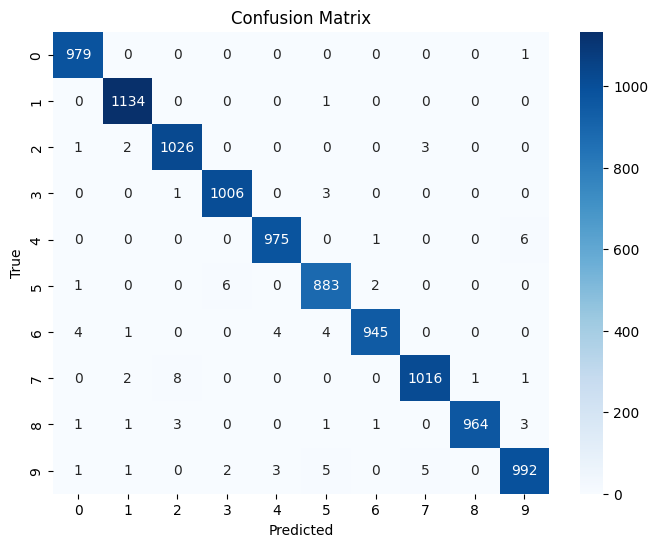


Classification Report:
               precision    recall  f1-score   support

           0     0.9919    0.9990    0.9954       980
           1     0.9939    0.9991    0.9965      1135
           2     0.9884    0.9942    0.9913      1032
           3     0.9921    0.9960    0.9941      1010
           4     0.9929    0.9929    0.9929       982
           5     0.9844    0.9899    0.9871       892
           6     0.9958    0.9864    0.9911       958
           7     0.9922    0.9883    0.9903      1028
           8     0.9990    0.9897    0.9943       974
           9     0.9890    0.9832    0.9861      1009

    accuracy                         0.9920     10000
   macro avg     0.9920    0.9919    0.9919     10000
weighted avg     0.9920    0.9920    0.9920     10000



In [7]:
# ----------------------------
# 4. Run Optuna
# ----------------------------
if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)

    print("Best Hyperparameters:", study.best_params)
    print("Best Validation Accuracy:", study.best_value)

    # ----------------------------
    # 5. Retrain with best params
    # ----------------------------
    best_params = study.best_params
    batch_size = best_params["batch_size"]
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = MNISTClassifier(
        hidden_size=best_params["hidden_size"],
        dropout_rate=best_params["dropout_rate"]
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"])
    criterion = nn.CrossEntropyLoss()

    epochs = 10
    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{epochs} finished")

    # Save model
    torch.save(model.state_dict(), "mnist_cnn.pth")
    print("Model saved as mnist_cnn.pth")

    # ----------------------------
    # 6. Evaluation on test set
    # ----------------------------
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Metrics
    accuracy = accuracy_score(all_labels, all_preds)
    print(f" Test Accuracy: {accuracy:.4f}")

    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds)
    for i in range(10):
        print(f"Digit {i}: P={precision[i]:.4f}, R={recall[i]:.4f}, F1={f1[i]:.4f}")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    print("\nClassification Report:\n", classification_report(all_labels, all_preds, digits=4))



## 9. Model Evaluation and Performance Metrics

Comprehensive evaluation of our trained model is essential to understand its performance. We'll evaluate on the test set using multiple metrics including accuracy, precision, recall, F1-score, and confusion matrix analysis to get a complete picture of model performance across all digit classes.

In [ ]:
# Comprehensive model evaluation on test set
'''Evaluate the model using multiple metrics:
- Overall accuracy and per-class accuracy
- Precision, recall, and F1-score for each digit class
- Confusion matrix for detailed error analysis
- Classification report with macro and weighted averages'''

# TODO: Implement comprehensive evaluation metrics

'Evaluate the model using multiple metrics:\n- Overall accuracy and per-class accuracy\n- Precision, recall, and F1-score for each digit class\n- Confusion matrix for detailed error analysis\n- Classification report with macro and weighted averages'

## 10. Adversarial Robustness Analysis

Adversarial robustness is a critical aspect of modern deep learning. We'll explore how well our model performs against adversarial attacks by generating adversarial examples using the Fast Gradient Sign Method (FGSM), implementing adversarial training techniques, and comparing performance on clean vs. adversarial test data.

In [ ]:
# Adversarial robustness implementation and evaluation
'''Implement and evaluate adversarial robustness:
- Generate adversarial examples using FGSM attack
- Retrain model with adversarial training techniques
- Compare accuracy and macro-F1 scores on clean vs. adversarial test sets
- Visualize adversarial examples and their effects'''

# TODO: Implement FGSM attack and adversarial training

'Implement and evaluate adversarial robustness:\n- Generate adversarial examples using FGSM attack\n- Retrain model with adversarial training techniques\n- Compare accuracy and macro-F1 scores on clean vs. adversarial test sets\n- Visualize adversarial examples and their effects'

## 11. Encoder-Based CNN Experiment

Feature learning through autoencoders can potentially improve classification performance while reducing model complexity. We'll train a convolutional autoencoder to learn meaningful latent representations, then use these features to train a smaller CNN classifier and compare its efficiency and performance against our baseline model.

In [ ]:
# Convolutional autoencoder for feature extraction
'''Train a convolutional autoencoder to extract meaningful latent features:
- Design encoder-decoder architecture for MNIST
- Train autoencoder for feature learning
- Use learned features to train a smaller CNN classifier
- Compare performance and efficiency to baseline CNN'''

# TODO: Implement convolutional autoencoder and feature-based classifier

'Train a convolutional autoencoder to extract meaningful latent features:\n- Design encoder-decoder architecture for MNIST\n- Train autoencoder for feature learning\n- Use learned features to train a smaller CNN classifier\n- Compare performance and efficiency to baseline CNN'

## GAN-Based Data Augmentation (Optional)

Generative Adversarial Networks (GANs) offer an advanced approach to data augmentation by generating synthetic training data. We'll implement a Deep Convolutional GAN (DCGAN) to generate MNIST-like images, augment our training set with these synthetic images, and evaluate whether this improves model performance compared to traditional augmentation techniques.

In [ ]:
# DCGAN implementation for synthetic data generation
'''Train a Deep Convolutional GAN to generate MNIST-like images:
- Implement generator and discriminator networks
- Train GAN with proper loss functions and optimization
- Generate synthetic MNIST images for data augmentation
- Retrain CNN with augmented dataset and compare results'''

# TODO: Implement DCGAN for data augmentation

'Train a Deep Convolutional GAN to generate MNIST-like images:\n- Implement generator and discriminator networks\n- Train GAN with proper loss functions and optimization\n- Generate synthetic MNIST images for data augmentation\n- Retrain CNN with augmented dataset and compare results'